## 依赖库导入

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
import os
from tqdm import tqdm
from typing import Dict, List, Tuple
import numpy as np
import torch.nn.functional as F
#画图启动
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## 载入数据

In [ ]:
!pip install -U gdown
#使用gdown下载处理好的数据
!gdown --id 1iJkUmRMIfttSIkcz2Dq8U6kpzOtmXjII -O train.csv
!gdown --id 1Ig0gA1XqgjDF00Re0GjnBERr6c1zUqPp -O test.csv
!gdown --id 1DHIQfnLJx7PJWACd_8RsWAAprsRfcR_B -O vocab.csv


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iJkUmRMIfttSIkcz2Dq8U6kpzOtmXjII
To: /content/train.csv
100% 18.9M/18.9M [00:00<00:00, 56.3MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ig0gA1XqgjDF00Re0GjnBERr6c1zUqPp
To: /content/test.csv
100% 18.9M/18.9M [00:00<00:00, 29.3MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.goo

In [ ]:
!ls

sample_data  test.csv  train.csv  vocab.csv


##数据处理部分

In [ ]:
class CSVDataset(Dataset):
    def __init__(self, file_path):
        # 读取 CSV 文件
        self.data = pd.read_csv(file_path)
        # 第一列是标签，第三列后是特征
        self.seqs = self.data.iloc[:, 2:].astype(int).values.tolist()
        self.labels = self.data.iloc[:, 0].astype(int).values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 转换为张量
        seq = torch.tensor(self.seqs[idx], dtype=torch.long)
        label = torch.tensor([self.labels[idx]], dtype=torch.float)
        return seq, label


In [ ]:
# 数据路径
train_path = 'train.csv'
test_path = 'test.csv'

# 创建训练集数据集实例
train_dataset = CSVDataset(train_path)

# 划分验证集，20% 作为验证集
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

test_dataset = CSVDataset(test_path)

# 创建 DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##模型构建

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,input_dim,num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads=num_heads
        self.head_dim=input_dim//num_heads

        # 检查embed_dim能否被num_heads整除
        assert (
            self.head_dim * num_heads == input_dim
        ), "embed_dim必须能被num_heads整除"

        #生成Q，K，V的线性层
        self.queries = nn.Linear(input_dim, input_dim)
        self.keys = nn.Linear(input_dim, input_dim)
        self.values = nn.Linear(input_dim, input_dim)

        # 多头注意力输出后的融合线性层
        self.fc_out = nn.Linear(input_dim, input_dim)

    def forward(self,x):
        #x:(batch_size, seq_len, input_dim)
        batch_size, seq_len, _=x.shape
        #生成Q，K，V
        # (batch_size, seq_length, input_dim)
        Q=self.queries(x)
        K=self.keys(x)
        V=self.values(x)

        #拆分为多头
        #(batch_size,seq_len,num_heads,head_dim)
        Q=Q.view(batch_size,seq_len,self.num_heads,self.head_dim)
        K=K.view(batch_size,seq_len,self.num_heads,self.head_dim)
        V=V.view(batch_size,seq_len,self.num_heads,self.head_dim)

        #变换顺序,便于注意力矩阵运算
        #(batch_size,num_heads,seq_len,head_dim)
        Q=Q.transpose(1,2)
        K=K.transpose(1,2)
        V=V.transpose(1,2)

        #注意力计算
        #（batch_size,num_heads,seq_len,seq_len）
        scores=torch.matmul(Q,K.transpose(-2,-1))
        #缩放
        scores=scores/math.sqrt(self.head_dim)
        #归一化为注意力权重
        #（batch_size,num_heads,seq_len,seq_len）
        attn_weights=torch.softmax(scores,dim=-1)

        #加权求和
        #（batch_size,num_heads,seq_len,head_dim）
        out=torch.matmul(attn_weights,V)

        #合并多头
        #(batch_size,seq_len,num_heads,head_dim)
        out=out.transpose(1,2)
        #(batch_size,seq_len,input_dim)
        out=out.reshape(batch_size,seq_len,self.input_dim)

        #线性变换
        #(batch_size,seq_len,input_dim)
        out=self.fc_out(out)
        return out


In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_dim,num_heads,p):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embed_dim)
        self.lstm=nn.LSTM(embed_dim,hidden_dim,batch_first=True)
        #注意力
        self.attention = MultiHeadAttention(input_dim=hidden_dim, num_heads=num_heads)
        self.dropout=nn.Dropout(p)
        self.fc=nn.Linear(hidden_dim,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
        #输入(batch_size, seq_len)
        embedded=self.dropout(self.embedding(x))
        #embedded:(batch_size, seq_len, embed_dim)
        output,_=self.lstm(embedded)
        output=self.dropout(output)
        #output:(batch_size, seq_len, hidden_dim)
        #注意力
        attn_out=self.dropout(self.attention(output))
        #attn_out:(batch_size, seq_len, hidden_dim)
        #平均池化，整句的表示
        pooled = attn_out.mean(dim=1)
        # pooled:(batch_size, hidden_dim)
        #dropout防止过拟合
        pooled = self.dropout(pooled)
        # 全连接层
        out = self.fc(pooled)
        # 激活函数
        out = self.sigmoid(out)
        return out

##模型训练

In [ ]:

def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                num_epochs: int,
                device: torch.device,
                checkpoint_dir: str = 'checkpoints') -> Tuple[Dict[str, List[float]], str]:

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # 创建checkpoints目录
    os.makedirs(checkpoint_dir, exist_ok=True)

    # 记录最佳验证准确率和对应的模型路径
    best_val_acc = 0.0
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

    model.to(device)

    # 训练循环
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc='Training')
        for batch_idx, (texts, labels) in enumerate(train_bar):
            # 将数据移到指定设备
            texts, labels = texts.to(device), labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            outputs = model(texts)
            loss = loss_fn(outputs, labels)

            # 反向传播
            loss.backward()
            optimizer.step()

            # 统计
            train_loss += loss.item()
            #_, predicted = outputs.max(1)
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            #train_correct += predicted.eq(labels).sum().item()
            train_correct += (predicted == labels).sum().item()

            # 更新进度条
            train_bar.set_postfix({
                'loss': f'{train_loss/(batch_idx+1):.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        # 计算训练指标
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Validation')
            for batch_idx, (texts, labels) in enumerate(val_bar):
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                # _, predicted = outputs.max(1)
                # val_total += labels.size(0)
                # val_correct += predicted.eq(labels).sum().item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{val_loss/(batch_idx+1):.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        # 计算验证指标
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # 打印当前轮次的结果
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # 如果当前验证准确率是最佳的，保存模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, best_model_path)
            print(f"保存最佳模型于 {best_model_path}，验证准确率: {val_acc:.2f}%")

    print(f"训练完成，最佳验证准确率: {best_val_acc:.2f}%")
    return history, best_model_path

def predict(model: nn.Module,
            test_loader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    用于二分类模型的预测函数（模型已包含sigmoid）
    """
    model.eval()
    predictions = []
    probabilities = []
    ground_truth = []

    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc='Predicting'):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)              # outputs 已是 sigmoid 后的概率
            preds = (outputs > 0.5).long()      # 不再用 sigmoid！

            predictions.extend(preds.cpu().numpy().flatten())
            probabilities.extend(outputs.cpu().numpy().flatten())  # outputs 就是概率
            ground_truth.extend(labels.cpu().numpy().flatten())

    return np.array(predictions), np.array(probabilities), np.array(ground_truth)


In [ ]:
vocab_size=10002
embed_dim=64
hidden_dim=128
num_heads=4
p=0.5
model=SentimentClassifier(vocab_size,embed_dim,hidden_dim,num_heads,p)
# 定义损失函数和优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.BCELoss()
num_epochs=10
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
history,best_model_path=train_model(
                    model,
                    train_loader,
                    val_loader,
                    optimizer,
                    loss_fn,
                    num_epochs,
                    device)




Epoch 1/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 87.08it/s, loss=0.5452, acc=71.97%]



Epoch 1/10:
Train Loss: 0.6479, Train Acc: 61.17%
Val Loss: 0.5452, Val Acc: 71.97%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 71.97%

Epoch 2/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 86.25it/s, loss=0.4733, acc=78.00%]



Epoch 2/10:
Train Loss: 0.5326, Train Acc: 73.49%
Val Loss: 0.4733, Val Acc: 78.00%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 78.00%

Epoch 3/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 88.13it/s, loss=0.3810, acc=83.62%]



Epoch 3/10:
Train Loss: 0.4430, Train Acc: 79.56%
Val Loss: 0.3810, Val Acc: 83.62%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 83.62%

Epoch 4/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 93.00it/s, loss=0.4088, acc=82.10%]



Epoch 4/10:
Train Loss: 0.3907, Train Acc: 82.69%
Val Loss: 0.4088, Val Acc: 82.10%

Epoch 5/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 95.31it/s, loss=0.3956, acc=83.16%]



Epoch 5/10:
Train Loss: 0.3512, Train Acc: 84.72%
Val Loss: 0.3956, Val Acc: 83.16%

Epoch 6/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 83.60it/s, loss=0.3395, acc=85.84%]



Epoch 6/10:
Train Loss: 0.3214, Train Acc: 86.19%
Val Loss: 0.3395, Val Acc: 85.84%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 85.84%

Epoch 7/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 92.12it/s, loss=0.3006, acc=87.58%]



Epoch 7/10:
Train Loss: 0.2950, Train Acc: 87.29%
Val Loss: 0.3006, Val Acc: 87.58%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 87.58%

Epoch 8/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 88.56it/s, loss=0.2868, acc=87.96%]



Epoch 8/10:
Train Loss: 0.2685, Train Acc: 88.50%
Val Loss: 0.2868, Val Acc: 87.96%
保存最佳模型于 checkpoints/best_model.pth，验证准确率: 87.96%

Epoch 9/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 87.49it/s, loss=0.3204, acc=86.66%]



Epoch 9/10:
Train Loss: 0.2524, Train Acc: 89.44%
Val Loss: 0.3204, Val Acc: 86.66%

Epoch 10/10


Validation: 100%|██████████| 79/79 [00:00<00:00, 94.01it/s, loss=0.3188, acc=87.00%]


Epoch 10/10:
Train Loss: 0.2322, Train Acc: 90.64%
Val Loss: 0.3188, Val Acc: 87.00%
训练完成，最佳验证准确率: 87.96%


In [ ]:
# 加载最优模型
checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 测试集评估
preds, probs, labels = predict(model, test_loader, device)

acc = accuracy_score(labels, preds)
print(f"测试集准确率: {acc * 100:.2f}%")

Predicting: 100%|██████████| 391/391 [00:04<00:00, 92.28it/s]

测试集准确率: 87.82%


##模型可视化评估

In [ ]:
def plot_training_history(history: Dict[str, List[float]], save_path: str = None, show: bool = True):
    """
    Plot training history: loss and accuracy curves (English version for Colab).

    Args:
        history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
        save_path: optional path to save the figure
        show: whether to display the plot
    """
    epochs = len(history['train_loss'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.rcParams['axes.unicode_minus'] = False  # Avoid minus sign being replaced

    # Plot loss
    ax1.plot(range(1, epochs + 1), history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(range(1, epochs + 1), history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Plot accuracy
    ax2.plot(range(1, epochs + 1), history['train_acc'], 'b-', label='Train Accuracy')
    ax2.plot(range(1, epochs + 1), history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Training history plot saved to: {save_path}")

    if show:
        plt.show()

    return fig, (ax1, ax2)

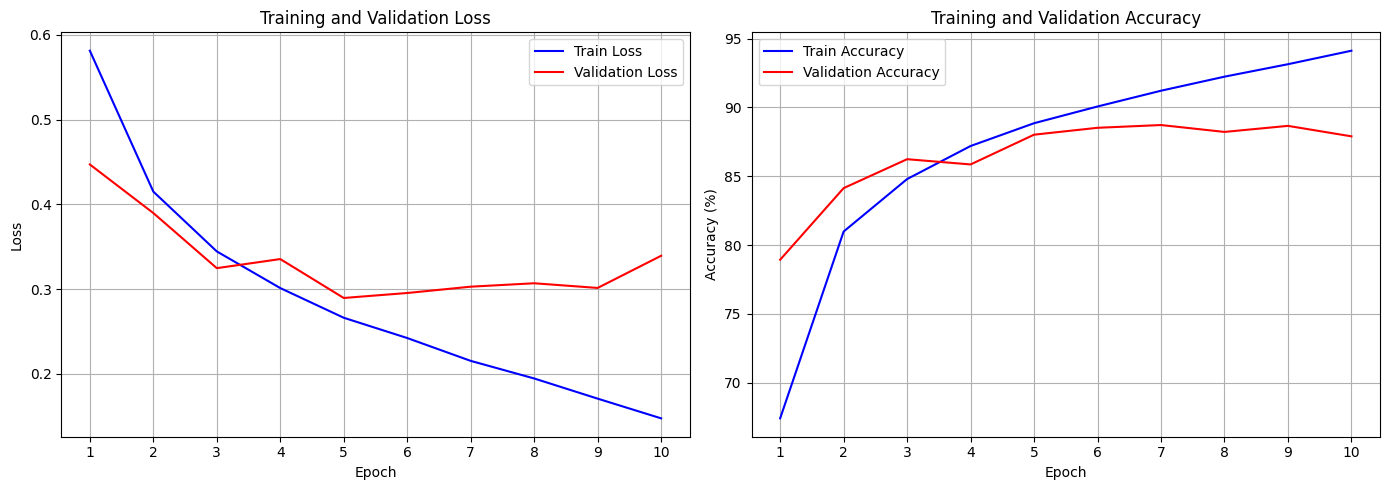

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': 'Training and Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
  <Axes: title={'center': 'Training and Validation Accuracy'}, xlabel='Epoch', ylabel='Accuracy (%)'>))

In [ ]:
# 画图并显示
plot_training_history(history)